In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
sys.path.append("meta_model")

In [2]:
benchmark_results = {}
benchmark_results_dir = "meta_dataset_creation/data/benchmark_results/"
clustering_algorithms = os.listdir(benchmark_results_dir)
clustering_algorithms

['fasterpam', 'haverage', 'kprototypes']

In [3]:
for algorithm in clustering_algorithms:
    benchmark_results[algorithm] = {}
    for name in os.listdir(os.path.join(benchmark_results_dir, algorithm)):
        benchmark_results[algorithm][name] = {}
        folder_path = os.path.join(benchmark_results_dir, algorithm, name)
        scores_dir = os.path.join(folder_path, "scores/")
        for filename in os.listdir(scores_dir):
            data_id = filename.split('.')[0]
            with open(os.path.join(scores_dir, filename), "rb") as f:
                result = pickle.load(f)
            for sim_pair in result:
                for eval_metric in result[sim_pair]:
                    if eval_metric not in benchmark_results[algorithm][name]:
                        benchmark_results[algorithm][name][eval_metric] = {}
                    if data_id not in benchmark_results[algorithm][name][eval_metric]:
                        benchmark_results[algorithm][name][eval_metric][data_id] = {}
                    benchmark_results[algorithm][name][eval_metric][data_id][sim_pair] = \
                        max([v["score"] for v in result[sim_pair][eval_metric]])
        for eval_metric in benchmark_results[algorithm][name]:
            benchmark_results[algorithm][name][eval_metric] = \
                pd.DataFrame.from_dict(benchmark_results[algorithm][name][eval_metric], orient='index')
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].fillna(-1)
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].replace(-1, -10)
            max_ = benchmark_results[algorithm][name][eval_metric].max(axis=1)
            benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric][max_ >= 0.7]
            print(algorithm, name, eval_metric, benchmark_results[algorithm][name][eval_metric].shape)

fasterpam original acc (85, 120)
fasterpam original ari (10, 120)
fasterpam original purity (113, 120)
fasterpam original sil (97, 120)


In [ ]:
algorithm = 'kprototypes'
eval_metric = 'sil'
benchmark_results[algorithm]["original"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_co-oc,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,...,pearson_iof,pearson_of,pearson_co-oc,pearson_jaccard,pearson_dice,pearson_kulsinski,pearson_rogerstanimoto,pearson_russellrao,pearson_sokalmichener,pearson_sokalsneath
10,0.581081,0.581081,0.581081,0.581081,0.581081,0.581081,0.581081,0.581081,0.581081,0.581081,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
1037,0.673670,0.672329,0.673000,0.674117,0.686410,0.673670,0.688198,0.671882,0.673894,0.671658,...,0.616227,0.604381,0.684399,0.645731,0.645731,0.604381,0.645731,0.604381,0.645731,0.645731
1057,0.526316,0.578947,0.644737,0.565789,0.605263,0.578947,0.578947,0.578947,0.592105,0.578947,...,0.644737,0.631579,0.434211,0.539474,0.605263,0.460526,0.631579,0.500000,0.631579,0.539474
1110,0.837000,0.862300,0.862500,0.893300,0.863400,0.836800,0.812100,0.846800,0.837000,0.837100,...,0.863600,0.872900,0.899700,0.846800,0.863800,0.863900,0.846500,0.873900,0.846500,0.851500
1116,0.537739,0.537739,0.537739,0.802516,-10.000000,0.537739,0.537739,0.537739,0.537739,0.537739,...,0.536072,0.802516,-10.000000,0.533495,0.533495,0.533495,0.533495,0.533495,0.533495,0.533495


In [ ]:
benchmark_results[algorithm]["from_numeric"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,euclidean_sokalmichener,...,pearson_co-oc,pearson_jaccard,pearson_dice,pearson_kulsinski,pearson_rogerstanimoto,pearson_russellrao,pearson_sokalmichener,pearson_sokalsneath,lorentzian_co-oc,divergence_co-oc
101_1543,0.431481,0.431481,0.437963,0.519444,0.314815,0.314815,0.295370,0.262963,0.295370,0.262963,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
106_1488,0.682051,0.676923,0.682051,0.682051,0.717949,0.717949,0.717949,0.671795,0.728205,0.671795,...,0.692308,0.712821,0.712821,0.712821,0.697436,0.712821,0.697436,0.717949,0.600000,0.656410
116_1413,0.780000,0.806667,0.780000,0.780000,0.780000,0.780000,0.793333,0.780000,0.793333,0.780000,...,-10.000000,0.726667,0.726667,0.726667,0.726667,0.726667,0.726667,0.726667,-10.000000,-10.000000
117_1065,0.866812,0.866812,0.866812,0.866812,0.866812,0.866812,0.871179,0.866812,0.901747,0.866812,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,0.866812,0.602620
126_1067,0.825984,0.854908,0.825984,0.825510,0.825984,0.825984,0.825984,0.825984,0.825984,0.825984,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,0.852537,0.667615


In [ ]:
dataset_statistics = ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",  # "kurtosis_num_att", "skewness_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

isolation_forest = [f"isolation_forest_{i}" for i in range(10)]

proposed_attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        # "kurtosis_squared_num_att", "skewness_squared_num_att",
        "means_squared_num_att", "std_squared_num_att",
        # "kurtosis_internal_product_num_att", "skewness_internal_product_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]

In [ ]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
mixed_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id").drop_duplicates()
mixed_meta_df.index = mixed_meta_df.index.astype(str)
print("Number of meta features:", mixed_meta_df.shape[1])
print("Number of instances:", mixed_meta_df.shape[0])

Number of meta features: 61
Number of instances: 91


In [ ]:
numeric_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id").drop_duplicates()
numeric_meta_df.index = numeric_meta_df.index.astype(str)
print("Number of meta features:", numeric_meta_df.shape[1])
print("Number of instances:", numeric_meta_df.shape[0])

Number of meta features: 61
Number of instances: 500


In [ ]:
from sklearn.metrics import pairwise_distances
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_Y = benchmark_results[algorithm]["original"][eval_metric][index.isin(mixed_meta_df.index)].to_numpy()
mixed_Yn = np.array([y/max(y) for y in mixed_Y])
mixed_Yn[mixed_Yn>0] **= 4
mixed_Yn[mixed_Yn<0] = -1

index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
numeric_Y = benchmark_results[algorithm]["from_numeric"][eval_metric][index.isin(numeric_meta_df.index)].to_numpy()
numeric_Yn = np.array([y/max(y) for y in numeric_Y])
numeric_Yn[numeric_Yn>0] **= 4
numeric_Yn[numeric_Yn<0] = -1

In [ ]:
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()

index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
numeric_X = numeric_meta_df.loc[[i for i in index if i in numeric_meta_df.index]].to_numpy()
sc = StandardScaler().fit(mixed_X) # StandardScaler().fit(np.concatenate((mixed_X, numeric_X))) #
mixed_X = sc.transform(mixed_X) # mixed_X/mixed_X.shape[1] #
numeric_X = sc.transform(numeric_X) # numeric_X/numeric_X.shape[1] #

mixed_X.shape, numeric_X.shape

((36, 61), (78, 61))

In [11]:
X = np.concatenate((mixed_X, numeric_X))
X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
Y = np.concatenate((mixed_Y, numeric_Y))
Yn = np.concatenate((mixed_Yn, numeric_Yn))

In [12]:
selected_datasets = np.array([i for i in range(mixed_X.shape[0])])
print(len(selected_datasets))

36


In [13]:
import random

import torch
import torch.nn as nn

from tqdm import tqdm

import typing
from typing import List

Parameters = List[torch.nn.parameter.Parameter]

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Pytorch will use device {device}")

# turn off gradients as we will not be needing them
torch.set_grad_enabled(False)

in_dim = X.shape[1]
out_dim = 16

print(in_dim, out_dim)

Pytorch will use device cuda:0
61 16


In [14]:
from sklearn.model_selection import cross_val_score, KFold
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
# from meta_model.ranking import scorer
import pygad

scorer = make_scorer(lambda yt, yp: np.mean([(y[y>0][np.argmax(yp[i][y>0])]/max(y))**1 for i, y in enumerate(yt)]))
# scorer = make_scorer(lambda yt, yp: np.mean(ndcg(yt, yp, p=5)))

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

def get_params(net: torch.nn.Sequential) -> Parameters:
    '''
    Gets the parameters from a PyTorch model stored as an nn.Sequential
    
    @params
        network (nn.Sequential): A pytorch model
    @returns
        Parameters: the parameters of the model
    '''
    params = []
    for layer in net:
        if hasattr(layer, 'weight') and layer.weight != None:
            params.append(layer.weight)
        if hasattr(layer, 'bias') and layer.bias != None:
            params.append(layer.bias)
    return params

def set_params(net: torch.nn.Sequential, params: Parameters) -> torch.nn.Sequential:
    '''
    Sets the parameters for an nn.Sequential
    
    @params
        network (torch.nn.Sequential): A network to change the parameters of 
        params (Parameters): Parameters to place into the model
    @returns
        torch.nn.Sequential: A model the the provided parameters
    '''
    i = 0
    for layerid, layer in enumerate(net):
        if hasattr(layer, 'weight') and layer.weight != None:
            net[layerid].weight = params[i]
            i += 1
        if hasattr(layer, 'bias') and layer.bias != None:
            net[layerid].bias = params[i]
            i += 1
    return net

def fitness(solution: Parameters, net: torch.nn.Sequential, X, Y) -> float:
    '''
    Evaluate a solution, a set of weights and biases for the network
    
    @params
        solution (Parameters): parameters to test the fitness of
        net (torch.nn.Sequential): A network for testing the parameters with
        render (bool): whether or not to draw the agent interacting with the environment as it trains
    @returns
        float: The fitness of the solution
    '''
    net = set_params(net, solution)

    # Xe = net(torch.tensor(X, device=device).float()).cpu().detach().numpy()
    # n_neighbors = 5
    # metric = "euclidean"
    # w = "distance"
    # knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    # fitness = np.mean(cross_val_score(knn, Xe, Y, cv=5, scoring=scorer))
    # return fitness
    yp = net(torch.tensor(X, device=device).float()).cpu().detach().numpy()
    return np.mean([(y[y>0][np.argmax(yp[i][y>0])]/max(y))**1 for i, y in enumerate(Y)])


def select(pop: List[Parameters], fitnesses: np.ndarray) -> List[Parameters]:
    '''
    Select a new population
    
    @params
        pop (List[Parameters]): The entire population of parameters
        fitnesses (np.ndarray): the fitnesses for each entity in the population
    @returns
        List[Parameters]: A new population made of fitter individuals
    '''
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True, p=fitnesses/fitnesses.sum())
    return [pop[i] for i in idx]

def crossover(parent1: Parameters, pop: List[Parameters]) -> Parameters:
    '''
    Crossover two individuals and produce a child.
    
    This is done by randomly splitting the weights and biases at each layer for the parents and then
    combining them to produce a child
    
    @params
        parent1 (Parameters): A parent that may potentially be crossed over
        pop (List[Parameters]): The population of solutions
    @returns
        Parameters: A child with attributes of both parents or the original parent1
    '''
    if np.random.rand() < CROSS_RATE:
        i = np.random.randint(0, POP_SIZE, size=1)[0]
        parent2 = pop[i]
        child = []
        split = np.random.rand()
        
        for p1l, p2l in zip(parent1, parent2):
            splitpoint = int(len(p1l)*split)
            new_param = nn.parameter.Parameter(torch.cat([p1l[:splitpoint], p2l[splitpoint:]]))
            child.append(new_param)

        return child
    else:
        return parent1


def gen_mutate(shape: torch.Size) -> torch.tensor:
    '''
    Generate a tensor to use for random mutation of a parameter
    
    @params
        shape (torch.Size): The shape of the tensor to be created
    @returns
        torch.tensor: a random tensor
    '''
    return torch.randn(shape).to(device)*MUTATION_FACTOR
    
def mutate(child: Parameters) -> Parameters:
    '''
    Mutate a child
    
    @params
        child (Parameters): The original parameters
    @returns
        Parameters: The mutated child
    '''
    for i in range(len(child)):
        for j in range(len(child[i])):
            child[i][j] += gen_mutate(child[i][j].shape)
    return child

In [16]:
%%time

# hyperparameters for genetic algorithm
POP_SIZE = 300
CROSS_RATE = 0.8
MUTATION_RATE = 0.2
MUTATION_FACTOR = 0.001
N_GENERATIONS = 50
FITNESS_EARLY_STOP_THRESH = 0.999

# the pytorch neural network to train
net = nn.Sequential(
    nn.Linear(in_dim, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, Y.shape[1]),
    nn.Softmax(dim=1),
).to(device)

# get the required parameter shapes
base = get_params(net)
shapes = [param.shape for param in base]

# build a population
pop = []
for i in range(POP_SIZE):
    entity = []
    for shape in shapes:
        # if fan in and fan out can be calculated (tensor is 2d) then using kaiming uniform initialisation
        # as per nn.Linear
        # otherwise use uniform initialisation between -0.5 and 0.5
        try:
            rand_tensor = nn.init.kaiming_uniform_(torch.empty(shape)).to(device)
        except ValueError:
            rand_tensor = nn.init.uniform_(torch.empty(shape), -0.2, 0.2).to(device)
        entity.append((torch.nn.parameter.Parameter(rand_tensor)))
    pop.append(entity)

# train
for i in range(N_GENERATIONS):
    # get fitnesses
    fitnesses = np.array([fitness(entity, net, X[selected_datasets], Y[selected_datasets]) for entity in pop])
    # fitnesses = np.array(Parallel(n_jobs=-1, verbose=0)(delayed(fitness)(entity, net, X[selected_datasets], Y[selected_datasets]) for entity in pop))
    # calculate average fitness of population
    avg_fitness = fitnesses.sum()/len(fitnesses)
    
    # print info of generation
    print(f"Generation {i}: Average Fitness is {avg_fitness} | Max Fitness is {fitnesses.max()}")
    
    if avg_fitness > FITNESS_EARLY_STOP_THRESH:
        break
    # select a new population
    
    fittest = list(pop[fitnesses.argmax()])
    pop = select(pop, fitnesses)
    random.shuffle(pop)
    pop = pop[:-1]
    pop.append(fittest)
    pop2 = list(pop)
    # go through the population and crossover and mutate
    for i in range(len(pop)-1):
        child = crossover(pop[i], pop2)
        child = mutate(child)
        pop[i] = child

Generation 0: Average Fitness is 0.8769789272059478 | Max Fitness is 0.9257879969758185
Generation 1: Average Fitness is 0.8778664946627964 | Max Fitness is 0.9257879969758185
Generation 2: Average Fitness is 0.8765116226934142 | Max Fitness is 0.9257879969758185
Generation 3: Average Fitness is 0.8754577889080827 | Max Fitness is 0.9257879969758185
Generation 4: Average Fitness is 0.8768328959933136 | Max Fitness is 0.9257879969758185
Generation 5: Average Fitness is 0.8775348252880436 | Max Fitness is 0.9256521898637047
Generation 6: Average Fitness is 0.8777946370523512 | Max Fitness is 0.9256521898637047
Generation 7: Average Fitness is 0.8789279084077797 | Max Fitness is 0.9256521898637047
Generation 8: Average Fitness is 0.8766990774934103 | Max Fitness is 0.9256521898637047
Generation 9: Average Fitness is 0.8764728235529543 | Max Fitness is 0.9256521898637047
Generation 10: Average Fitness is 0.8782066555805527 | Max Fitness is 0.9257879969758185
Generation 11: Average Fitness 

In [73]:
fittest = pop[fitnesses.argmax()]
net = set_params(net, fittest)
net[0].weight[0]

tensor([-0.0622, -0.0605,  0.0980,  0.2098,  0.1671, -0.1797,  0.3178,  0.0125,
        -0.2456, -0.0928,  0.2699, -0.3508, -0.2094, -0.2140,  0.0489, -0.1986,
        -0.0134,  0.2438, -0.0289,  0.0801,  0.1494, -0.2351,  0.3052, -0.2622,
        -0.2038,  0.1692, -0.0907, -0.2746, -0.2455,  0.1219,  0.2886, -0.0711,
        -0.3443,  0.3036, -0.0282, -0.1361, -0.2627,  0.2110, -0.1482, -0.1224,
         0.1927,  0.1776,  0.1716, -0.3627,  0.2703, -0.1485, -0.2277, -0.0541,
        -0.1773,  0.2760, -0.2668, -0.1006, -0.1682,  0.1847,  0.0873,  0.2022,
        -0.3255, -0.2425,  0.1291, -0.2608, -0.2896], device='cuda:0',
       requires_grad=True)

In [89]:
from meta_model.utils import ndcg
from meta_model.ranking import ALL_MODELS
from meta_model.ranking_tree import RankingTree
from sklearn.model_selection import KFold, cross_val_predict

models = {
    # "KNN": ALL_MODELS["KNN"](),
    # "KNN-FS": ALL_MODELS["KNN"](),
    "KNN-AMF": ALL_MODELS["KNN"](),
    "KNN-AMF-FS": ALL_MODELS["KNN"](),
    # "RT": ALL_MODELS["RT"](min_samples_split=3),
}
cv = KFold(n_splits=5)
predictions = {model_name: np.zeros(shape=(len(selected_datasets), 120)) for model_name in models}
predictions["AR"] = np.zeros(shape=(len(selected_datasets), 120))
i = 0

# models["KNN"] = models["KNN"].cross_val_fit(X2[selected_datasets], Y[selected_datasets], n_splits=5) #
# predictions["KNN"] = cross_val_predict(models["KNN"], X2[selected_datasets], Y[selected_datasets], cv=cv)

# n_neighbors = solution2[X2.shape[1]]
# metric = metrics[solution2[X2.shape[1]+1]]
# w = weights[solution2[X2.shape[1]+2]]
# knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
# predictions["KNN-FS"] = cross_val_predict(knn, X2[selected_datasets][:, selected_features2], Y[selected_datasets], cv=cv)

models["KNN-AMF"] = models["KNN-AMF"].cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=5) #
predictions["KNN-AMF"] = cross_val_predict(models["KNN-AMF"], X[selected_datasets], Y[selected_datasets], cv=5)

# fittest = pop[fitnesses.argmax()]
# net = set_params(net, fittest)
# Xe = net(torch.tensor(X[selected_datasets], device=device).float()).cpu().detach().numpy()
# models["KNN-AMF-FS"], cv_scores = models["KNN-AMF-FS"].cross_val_fit(Xe, Y[selected_datasets], n_splits=5, return_cv_scores=True) #
# predictions["KNN-AMF-FS"] = cross_val_predict(models["KNN-AMF-FS"], Xe, Y[selected_datasets], cv=5)

fittest = pop[fitnesses.argmax()]
net = set_params(net, fittest)
Xe = net(torch.tensor(X[selected_datasets], device=device).float()).cpu().detach().numpy()
n_neighbors = 5
metric = "euclidean"
w = "distance"
knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
predictions["KNN-AMF-FS"] = cross_val_predict(knn, Xe, Y[selected_datasets], cv=5)

for train, test in cv.split(X[selected_datasets]):
    predictions["AR"][test] = np.array([
        [np.mean([v for v in Y[train, j]]) for j in range(Y.shape[1])]
        for _ in test
    ])
# predictions["AR"][selected_datasets[test]] = np.array([
#     [np.mean([v for v in Y[selected_datasets[train], j] if v > 0]) for j in range(Y.shape[1])]
#     for _ in test
# ])

In [86]:
models["KNN-AMF-FS"].get_params()

{'metric': <function scipy.stats._stats_py.wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None)>,
 'n_neighbors': 10,
 'weights': 'uniform'}

In [83]:
baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}
similarity_pairs = benchmark_results[algorithm]["original"][eval_metric].columns
sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]
ndcg_scores = {
    model_name: {p: np.zeros(len(selected_datasets)) for p in ndcg_ranks}
    for model_name in predictions
} #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

lb_scores = np.zeros(len(selected_datasets))
rb_scores = {k: np.zeros(len(selected_datasets)) for k in n_bests}
mb_scores = np.zeros(len(selected_datasets))
model_scores = {
    model_name: {k: np.zeros(len(selected_datasets)) for k in n_bests}
    for model_name in predictions
} #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for p in ndcg_ranks:
        ndcg_scores[name][p] = ndcg(Yn[selected_datasets], Y_pred, p=p)

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for k in n_bests:
        model_scores[name][k] = np.array(
            [max(y[y > 0][np.argsort(-Y_pred[i][y > 0])[:k]]) for i, y in enumerate(Y[selected_datasets])])

for k in n_bests:
    rb_scores[k] = np.array(
        [max(np.random.choice(y[y > 0], k)) for y in Y[selected_datasets]])

lb_scores = Y[selected_datasets][:, sim_pairs_index[baseline_pairs[algorithm]]]
mb_scores = np.array([max(y) for y in Y[selected_datasets]])

c:\Users\abdou\Documents\Workspace\Recherche\simrec-for-mdc\venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abdou\Documents\Workspace\Recherche\simrec-for-mdc\venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


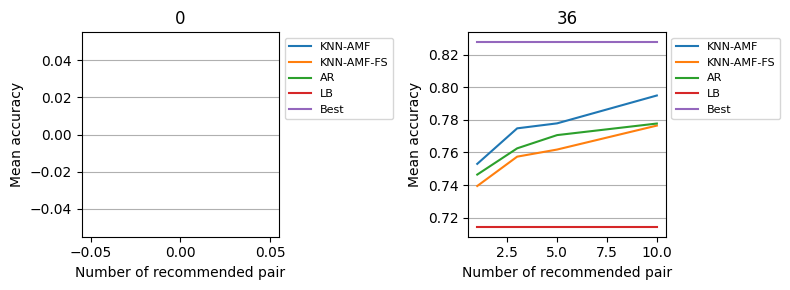

In [84]:
import matplotlib.pyplot as plt

list_indices = [
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) < 0.0], #test_index[i] in base_datasets and # i in test and
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]
]
rows, cols = 1, len(list_indices)
plt.figure(figsize=(cols*4, rows*3))
subplot_num = 1
exclude = [] #"KNN with aug.", "RF with aug." - "KNN", "RF", "AE+KNN", "AE+RF"
for indices in list_indices:
    scores = {k:v for k, v in model_scores.items() if k not in exclude} 
    # scores["RB"] = rb_scores
    scores["LB"] = lb_scores
    scores["Best"] = mb_scores

    y = {key: [] for key in scores}

    for name, score in scores.items():
        for k in n_bests:
            u = score[indices] if name in ["LB", "Best"] else score[k][indices]
            y[name].append(np.mean(u))

    plt.subplot(rows, cols, subplot_num)
    for name, values in y.items():
        plt.plot(n_bests, values, label=name)
    plt.ylabel("Mean accuracy")
    plt.xlabel("Number of recommended pair")
    # plt.ylim((0.67, 0.9))
    plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
    plt.grid(axis="y")
    plt.title(len(indices))
    subplot_num += 1
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

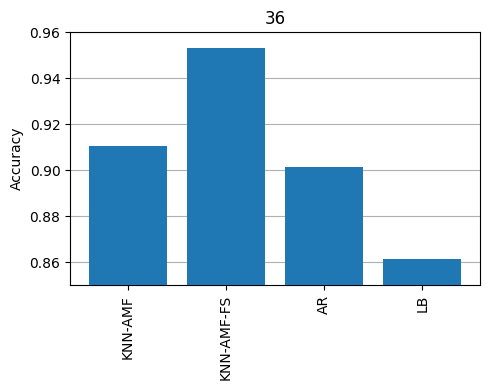

In [80]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 1
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = np.mean(u/best_scores)

plt.figure(figsize=(5, 4))
plt.bar(y.keys(), y.values(), zorder=5)
plt.ylabel("Accuracy")
plt.ylim((0.85, 0.96))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

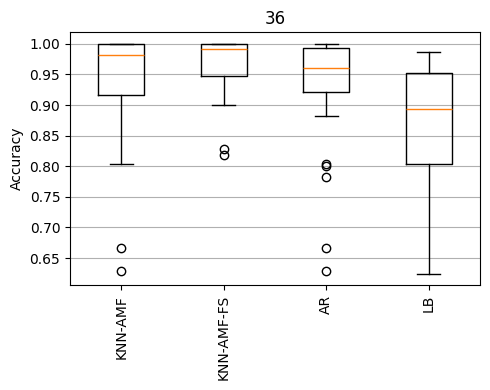

In [81]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 5
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = u/best_scores

plt.figure(figsize=(5, 4))
plt.boxplot(y.values(), labels=y.keys())
plt.ylabel("Accuracy")
# plt.ylim((0.67, 0.9))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

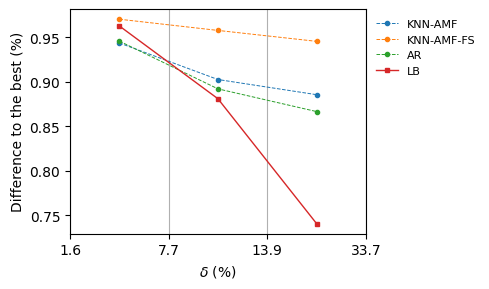

In [50]:
baselines = ["LB"]
k = 1
plt.figure(figsize=(5, 3))
# if j == 0:
#     ax = plt.subplot(2, 1, 1)
# else:
#     ax = plt.subplot(2, 1, 2)
# res = results[algo]

best_scores = mb_scores
y = {}
l = [np.mean(1 - y[y>0]/max(y)) for i, y in enumerate(Y[selected_datasets])]
x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])

x[0] -= 1e-4
diff = 0.025
list_indices = [
    [xr < np.mean(1 - y[y>0]/max(y)) <= x[r+1] for i, y in enumerate(Y[selected_datasets])]
    for r, xr in enumerate(x[:-1])
] #

for model_name, scores in model_scores.items():
    y[model_name] = []
    for i, indices in enumerate(list_indices):
        # new_ind = [val and lb_scores[j] >, 0, for j, val in enumerate(indices)]
        v = np.mean(((scores[k])/best_scores)[indices])
        y[model_name].append(v)

y["LB"] = []
for i, indices in enumerate(list_indices):
    v = np.mean(((lb_scores)/best_scores)[indices])
    y["LB"].append(v)

n_bar = len(y)
w = 0.8/n_bar
z = np.arange(len(x))
i = 0
max_ = np.zeros(len(list_indices))
min_ = np.ones(len(list_indices))*100
for model_name, values in y.items():
    max_ = np.maximum(max_, values)
    min_ = np.minimum(min_, values)
    # plt.plot(z[:-1]+0.5, values, "--", linewidth=0.7, label=None, alpha=1 if i<6 else 0.7, zorder=10)
    # plt.scatter(z[:-1]+0.5, values, label=model_name, s=[10*np.log(sum(val)) for val in list_indices], alpha=1 if i<6 else 0.7, zorder=10)
    plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7 if model_name not in baselines else 1, label=model_name, markersize=3, zorder=10)
    i += 1

for ind, val in enumerate(list_indices):
    if ind >= 1:
        plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center", va="top")

# plt.bar(x[1:]-diff/2, [50 for _ in diff], width=diff[0], zorder=0, label=None, color="None", edgecolor="gray")

plt.xlim((z[0], z[-1]))
plt.ylabel("Difference to the best (%)")
plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x])
# plt.ylim((min(min_)-1, max(max_)+1))
plt.grid(axis="x")
plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
plt.xlabel("$\delta$ (%)")

# if j == 0:
#     plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
# if j == 1: 
#     plt.xlabel("$\delta$ (%)")
# j += 1
# plt.title(names[algo], y=0.83)

plt.tight_layout()
# if savedir is not None:
#     plt.savefig(os.path.join(savedir, f"diff_best_delta_{algo}_{k}.pdf"))
plt.show()

In [ ]:
from scipy.stats import wilcoxon

model_names = ["KNN", "KNN-AMF-FS"]
baselines = ["LB", "RB", "ARB"]
y = {k:{} for k in model_names}
y_ndcg = {k:{} for k in model_names}

for model_name in model_names:
    scores = model_scores[model_name][1]
    baseline_scores = model_scores["AR"][1]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(top-1) ARB"] = f"{p:.3f}"

    baseline_scores = ndcg_scores["AR"][10]
    scores = ndcg_scores[model_name][10]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(NDCG) ARB"] = f"{p:.3f}"

print(pd.DataFrame.from_dict(y, orient='index'))

           (top-1) ARB (NDCG) ARB
KNN              0.721      0.715
KNN-AMF-FS       0.001      0.014


/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
